In [52]:
from ekpy import analysis
import numpy as np
import scipy.integrate as it
from scipy.signal import savgol_filter
from sklearn.preprocessing import MinMaxScaler

In [2]:
# load the dataset
dset = analysis.load_Dataset('./testnew')

# print dset, parsable collection of meta data which holds pointers to the real data files
dset

,initial_delay,pulse_delay,freq,voltage,capacitor_area,thickness,permittivity,amplification,format,type,points,count,x_increment,x_origin,x_reference,y_increment,y_origin,y_reference,trial,filename
0,0.00005,0.000005,10,0.5,4.000000e-08,1.000000e-08,30,8,0,0,995,1,4.720000e-07,2.710505e-20,0,0.005025,0.0,0,0,fe_pv__0.csv
1,0.00005,0.000005,10,1.0,4.000000e-08,1.000000e-08,30,8,0,0,995,1,4.720000e-07,2.710505e-20,0,0.010050,0.0,0,0,fe_pv__1.csv
2,0.00005,0.000005,10,1.5,4.000000e-08,1.000000e-08,30,8,0,0,995,1,4.720000e-07,2.710505e-20,0,0.015075,0.0,0,0,fe_pv__2.csv


In [3]:
data = dset.get_data()

In [20]:
data2 = dset.query("voltage == 1").get_data()

In [21]:
data2.summary

{'initial_delay': {5e-05},
 'pulse_delay': {5e-06},
 'freq': {10},
 'voltage': {1.0},
 'capacitor_area': {4e-08},
 'thickness': {1e-08},
 'permittivity': {30},
 'amplification': {8},
 'format': {0},
 'type': {0},
 'points': {995},
 'count': {1},
 'x_increment': {4.72e-07},
 'x_origin': {2.71050543e-20},
 'x_reference': {0},
 'y_increment': {0.0100502502173185},
 'y_origin': {0.0},
 'y_reference': {0},
 'trial': {0}}

In [22]:
data2.data_keys

['time_v', 'wfm_v', 'time_c', 'wfm_c']

(<Figure size 640x480 with 1 Axes>, <Axes: >)

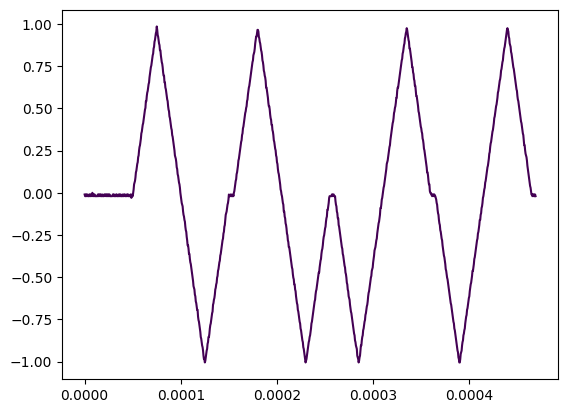

In [23]:
data2.plot(x='time_v', y='wfm_v')

(<Figure size 640x480 with 1 Axes>, <Axes: >)

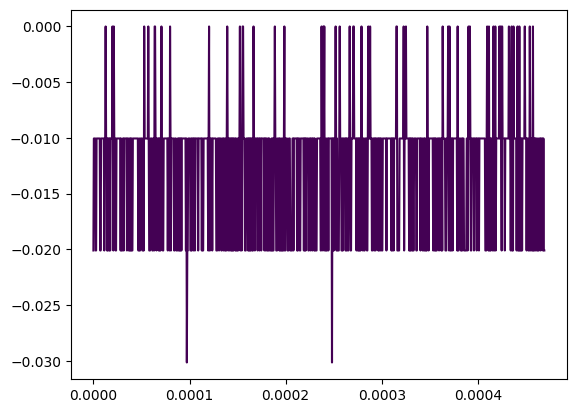

In [24]:
data2.plot(x='time_c', y='wfm_c')

use data.definition (no parenthesis) to get all the meta data associated with the exp for all trials in the dset

We may need to normalize the data for the wfm c to 0, aka shift it correspondingly. not sure why since it should be doing that but I will have to think about it

In [16]:
type(data2) #this is already a numpy array lets fucking gooo

ekpy.analysis.core.Data

In [19]:
data['time_v']

{0: array([2.71050543e-20, 4.72000000e-07, 9.44000000e-07, 1.41600000e-06,
        1.88800000e-06, 2.36000000e-06, 2.83200000e-06, 3.30400000e-06,
        3.77600000e-06, 4.24800000e-06, 4.72000000e-06, 5.19200000e-06,
        5.66400000e-06, 6.13600000e-06, 6.60800000e-06, 7.08000000e-06,
        7.55200000e-06, 8.02400000e-06, 8.49600000e-06, 8.96800000e-06,
        9.44000000e-06, 9.91200000e-06, 1.03840000e-05, 1.08560000e-05,
        1.13280000e-05, 1.18000000e-05, 1.22720000e-05, 1.27440000e-05,
        1.32160000e-05, 1.36880000e-05, 1.41600000e-05, 1.46320000e-05,
        1.51040000e-05, 1.55760000e-05, 1.60480000e-05, 1.65200000e-05,
        1.69920000e-05, 1.74640000e-05, 1.79360000e-05, 1.84080000e-05,
        1.88800000e-05, 1.93520000e-05, 1.98240000e-05, 2.02960000e-05,
        2.07680000e-05, 2.12400000e-05, 2.17120000e-05, 2.21840000e-05,
        2.26560000e-05, 2.31280000e-05, 2.36000000e-05, 2.40720000e-05,
        2.45440000e-05, 2.50160000e-05, 2.54880000e-05, 2.596

In [ ]:
data.iloc[0].plot(x='time_v', y='wfm_v')

In [ ]:
data.plot()

In [25]:
def generate_q_wfm(data_dict) -> 'dict':
    wfm_q = it.cumulative_trapezoid(data_dict['wfm_c'], data_dict['time_c'], initial=0) 
    data_dict['wfm_q'] = wfm_q
    return data_dict

In [33]:
def generate_q_wfm_wrong(data_dict) -> 'dict':
    wfm_q = it.cumulative_trapezoid(data_dict['wfm_v'], data_dict['time_v'], initial=0) 
    data_dict['wfm_q_wrong'] = wfm_q
    return data_dict

In [30]:
newwwwww = data2.apply(generate_q_wfm)

(<Figure size 640x480 with 1 Axes>, <Axes: >)

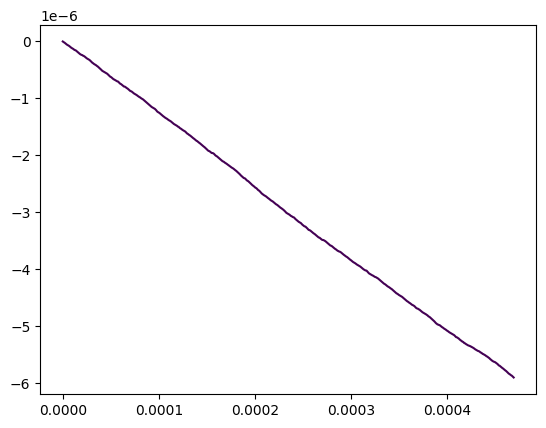

In [31]:
newwwwww.plot(x='time_c', y='wfm_q') #IT WORKS!!

In [34]:
wrong = data2.apply(generate_q_wfm_wrong)

(<Figure size 640x480 with 1 Axes>, <Axes: >)

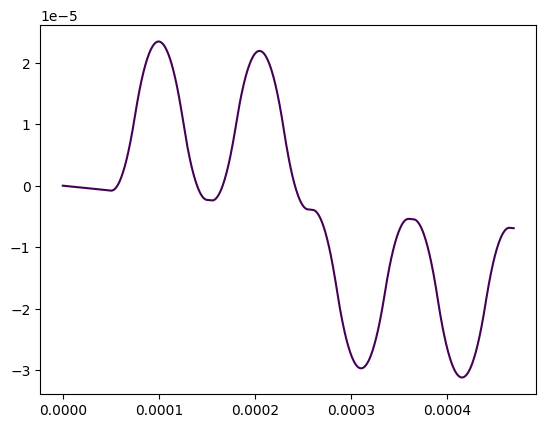

In [35]:
wrong.plot(x='time_v', y='wfm_q_wrong')

Now we need to convert this to polarization plot vs voltage. We are using the derivative of the waveform to essentially find out when the wavefoprm starts and ends
1. First take derivative of wfm
2. Then find points where it starts

In [48]:
def derivative(data_dict)->'dict':
    wfm_int = np.gradient(data_dict['wfm_v'], data_dict['time_v'])
    #add smoothing?
    wfm_int_smooth = savgol_filter(wfm_int, 51, 3)
    #normalize values to 1
    norm_val = np.linalg.norm(wfm_int_smooth)
    wfm_int_smooth_norm = wfm_int_smooth/norm_val
    data_dict['wfm_int'] = wfm_int_smooth_norm
    return data_dict

In [49]:
wrong2 = data2.apply(derivative)

(<Figure size 640x480 with 1 Axes>, <Axes: >)

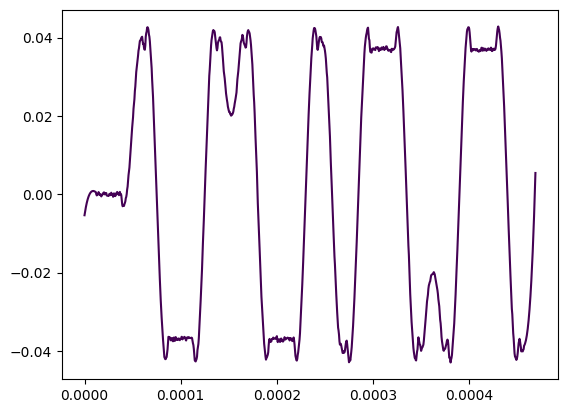

In [51]:
wrong2.plot(x='time_v', y='wfm_int')